In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline

# Final Project

# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [3]:
# Imports loan data

df = pd.DataFrame()
files = os.listdir('./Source Data/Loan Data')
csvs = []
for file in files:
    if re.match('.*csv$',file):
        csvs += [file]
cols = df.dtypes
for csv in csvs:
    path = './Source Data/Loan Data/' + csv
    tdf = pd.read_csv(path,header=1,low_memory=False,)
    df=df.append(tdf)
df.reset_index(inplace=True) # This will help with joining back data if necessary.

In [4]:
pd.set_option('display.max_rows', 160)
print(df.dtypes)
pd.set_option('display.max_rows', 20)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [5]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [6]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
#print(len(has_data))
has_data

{'index': 1873317,
 'id': 1873317,
 'member_id': 0,
 'loan_amnt': 1873290,
 'funded_amnt': 1873290,
 'funded_amnt_inv': 1873290,
 'term': 1873290,
 'int_rate': 1873290,
 'installment': 1873290,
 'grade': 1873290,
 'sub_grade': 1873290,
 'emp_title': 1751367,
 'emp_length': 1758942,
 'home_ownership': 1873290,
 'annual_inc': 1873286,
 'verification_status': 1873290,
 'issue_d': 1873290,
 'loan_status': 1873290,
 'pymnt_plan': 1873290,
 'url': 1873290,
 'desc': 126067,
 'purpose': 1873290,
 'title': 1849965,
 'zip_code': 1873289,
 'addr_state': 1873290,
 'dti': 1872449,
 'delinq_2yrs': 1873261,
 'earliest_cr_line': 1873261,
 'fico_range_low': 1873290,
 'fico_range_high': 1873290,
 'inq_last_6mths': 1873260,
 'mths_since_last_delinq': 930745,
 'mths_since_last_record': 311441,
 'open_acc': 1873261,
 'pub_rec': 1873261,
 'revol_bal': 1873290,
 'revol_util': 1871931,
 'total_acc': 1873261,
 'initial_list_status': 1873290,
 'out_prncp': 1873290,
 'out_prncp_inv': 1873290,
 'total_pymnt': 187

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

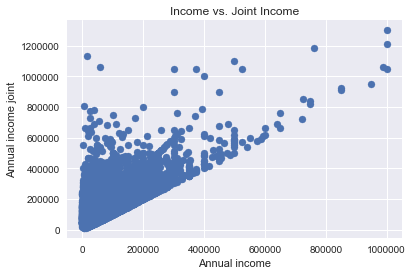

In [7]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;

Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [8]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data
# Convert the loan issue date to a datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2
# larger fico ranges might suggest greater uncertainty 
#reduced_df['fico_range'] = (reduced_df['fico_range_high']-reduced_df['fico_range_low'])
reduced_df.drop(columns=[
    'fico_range_low',
    'fico_range_high',
],inplace=True)
print(reduced_df.shape)

(1020552, 68)


In [9]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
#reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x: float(x[:-1]))

print(reduced_df.shape)

(1020552, 68)


In [10]:
#try to convert revol_util to a float
#print(reduced_df.dtypes)
#df['revol_util'] = df['revol_util'].astype(float)
#reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x: x[:-1])
#for val in reduced_df['revol_util']:
#    #if type(reduced_df['revol_util'][i]) is str: reduced_df['revol_util'][i]=i[:-1]
#    print("-%s-" % val)

In [11]:
backup_df=pd.DataFrame.copy(reduced_df)
print(backup_df.shape)

(1020552, 68)


In [12]:
reduced_df=pd.DataFrame.copy(backup_df)
print(reduced_df.shape)

(1020552, 68)


# Which variables are categorical?

In [13]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:14]:
    print(i, n_options[i],reduced_df[i].unique())


out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type 2 ['Individual' 'Joint App']
term 2 [' 60 months' ' 36 months']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
home_ownership 6 ['RENT' 'MORTGAGE' 'OWN' 'NONE' 'OTHER' 'ANY']
inq_last_6mths 10 [ 0.  1.  2.  4.  3.  5.  6.  7.  8. nan]
chargeoff_within_12_mths 11 [ 0.  1.  2.  3.  4.  5.  7.  6. 10.  8. nan]
emp_length 12 [ 4.  5. 10.  2.  7.  3.  6.  1.  8.  9.  0. nan]
pub_rec_bankruptcies 13 [ 0.  1.  2.  4.  3.  8.  5.  6.  7. 12.  9. 11. nan]
collections_12_mths_ex_med 15 [ 0.  1.  2.  4.  3.  6. 16. 20.  5. 10. 14. 12.  7. nan  9.]
open_il_12m 19 [nan  0.  2.  1.  3.  4.  6.  5.  9.  7.  8. 10. 12. 11. 13. 21. 25. 14.
 20.]
open_acc_6m 20 [nan  0.  2.  3.  6.  1.  4.  5.  9.  7.  8. 10. 14. 12. 11. 16. 18. 13.
 17. 15.]
mths_since_recent_inq 27 [14.  3. 17. 12.  7. nan  8.  0.  4.  6. 10.  2. 20. 11.  5.  9. 16.  1.
 13. 21. 19. 23. 18. 15. 22. 24. 25.]


Based on these results, we will have to encode several terms as dummy variables:
- 'application_type'
- 'term'
- 'verification_status'
- 'home_ownership'


In [14]:
#print(reduced_df.shape)
seta=set(reduced_df.columns)

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status',
                                                   'home_ownership'],
                          drop_first=True)

#print(reduced_df.shape)
setb=set(reduced_df.columns)

print(setb-seta)

{'term_ 60 months', 'home_ownership_RENT', 'verification_status_Verified', 'home_ownership_NONE', 'application_type_Joint App', 'home_ownership_OTHER', 'home_ownership_MORTGAGE', 'verification_status_Source Verified', 'home_ownership_OWN'}


# How to treat NaN

For now, let's remove majority NaN columns...

In [15]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i,j in zip(order_has_data[0:19],range(20)):
    print(j, i, has_data[i])

0 mths_since_last_record 172185
1 mths_since_recent_bc_dlq 240759
2 mths_since_last_major_derog 264308
3 mths_since_rcnt_il 289098
4 all_util 296067
5 inq_last_12m 296092
6 open_acc_6m 296092
7 total_cu_tl 296092
8 inq_fi 296093
9 open_il_12m 296093
10 open_il_24m 296093
11 open_rv_12m 296093
12 open_rv_24m 296093
13 mths_since_recent_revol_delinq 338379
14 mths_since_last_delinq 503506
15 mths_since_recent_inq 881746
16 mo_sin_old_il_acct 924972
17 pct_tl_nvr_dlq 952881
18 mo_sin_old_rev_tl_op 953024


In [16]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:16])

In [17]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:14]:
    print(i, n_options[i],nonnan_df[i].unique())

6889 866126
(866126, 57)
out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type_Joint App 2 [0 1]
term_ 60 months 2 [1 0]
verification_status_Source Verified 2 [0 1]
verification_status_Verified 2 [1 0]
home_ownership_MORTGAGE 2 [0 1]
home_ownership_NONE 2 [0 1]
home_ownership_OTHER 2 [0 1]
home_ownership_OWN 2 [0 1]
home_ownership_RENT 2 [1 0]
inq_last_6mths 9 [0. 1. 2. 4. 3. 5. 6. 7. 8.]
chargeoff_within_12_mths 10 [ 0.  1.  2.  3.  4.  5.  6.  7. 10.  8.]
emp_length 11 [ 4.  5. 10.  2.  7.  6.  3.  1.  8.  9.  0.]


In [18]:
nonnan_df.dtypes

acc_open_past_24mths                   float64
annual_inc                             float64
bc_open_to_buy                         float64
chargeoff_within_12_mths               float64
collection_recovery_fee                float64
collections_12_mths_ex_med             float64
delinq_2yrs                            float64
dti                                    float64
earliest_cr_line                        object
emp_length                             float64
                                        ...   
fico_est                               float64
application_type_Joint App               uint8
term_ 60 months                          uint8
verification_status_Source Verified      uint8
verification_status_Verified             uint8
home_ownership_MORTGAGE                  uint8
home_ownership_NONE                      uint8
home_ownership_OTHER                     uint8
home_ownership_OWN                       uint8
home_ownership_RENT                      uint8
Length: 57, d

In [19]:
# remove objects - need to convert them at some point
nonnan_df=nonnan_df.drop(columns=['revol_util','earliest_cr_line'])


# What factors are correlated?

Factors with high correlation (> 0.7) are:
acc_open_past_24mths vs num_tl_op_past_12m
bc_open_to_buy vs total_bc_limit
installment vs loan_amnt
installment vs total_pymnt
loan_amnt vs installment
loan_amnt vs total_pymnt
num_bc_sats vs num_bc_tl
num_bc_sats vs num_op_rev_tl
num_bc_tl vs num_bc_sats
num_bc_tl vs num_rev_accts
num_op_rev_tl vs num_bc_sats
num_op_rev_tl vs num_rev_accts
num_op_rev_tl vs num_rev_tl_bal_gt_0
num_op_rev_tl vs num_sats
num_op_rev_tl vs open_acc
num_rev_accts vs num_bc_tl
num_rev_accts vs num_op_rev_tl
num_rev_tl_bal_gt_0 vs num_op_rev_tl
num_sats vs num_op_rev_tl
num_sats vs open_acc
num_tl_op_past_12m vs acc_open_past_24mths
open_acc vs num_op_rev_tl
open_acc vs num_sats
revol_bal vs total_rev_hi_lim
total_bal_ex_mort vs total_il_high_credit_limit
total_bc_limit vs bc_open_to_buy
total_bc_limit vs total_rev_hi_lim
total_il_high_credit_limit vs total_bal_ex_mort
total_pymnt vs installment
total_pymnt vs loan_amnt
total_rev_hi_lim vs revol_bal
total_rev_hi_lim

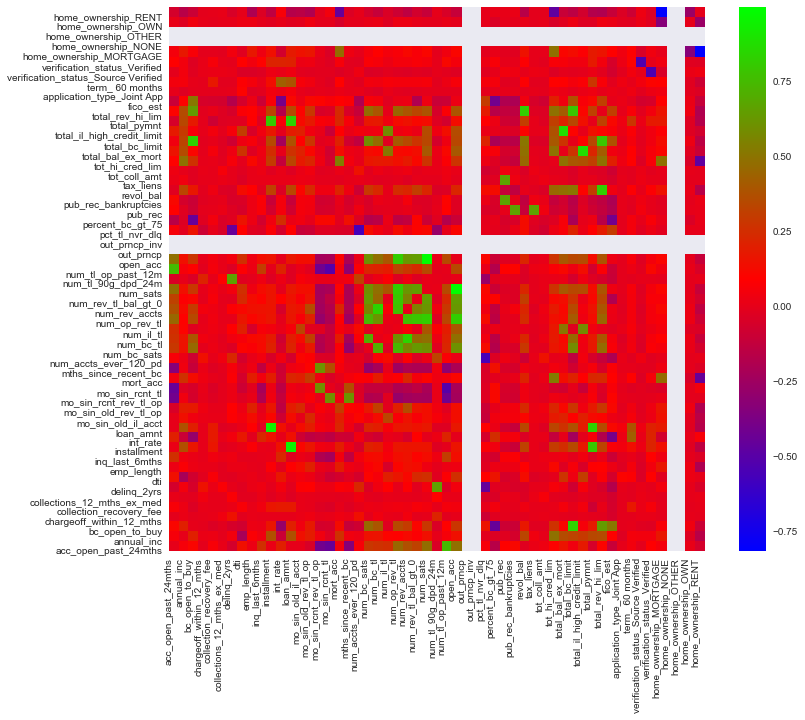

In [20]:
# your code here
# remove the self-correlation value of 1 by subtracting identity matrix

matrix=np.zeros(len(nonnan_df.columns))
for i in range(10):
    small_df=nonnan_df.iloc[np.random.choice(len(nonnan_df), len(nonnan_df)//100, replace=False)]
    temp_matrix=np.corrcoef(small_df,rowvar=False)-np.eye(len(small_df.columns))
    matrix=matrix+temp_matrix

matrix=matrix/10
#print(matrix)
i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> 0.7) are:")
for k in range(len(i)):
    print(nonnan_df.columns[i[k]],"vs",nonnan_df.columns[j[k]])

plt.figure(figsize=(12,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(nonnan_df.columns)), nonnan_df.columns,rotation='vertical')
plt.yticks(range(len(nonnan_df.columns)), nonnan_df.columns)
plt.colorbar(cmap='brg')
plt.show()

# Let's work with training and test sets
IMPORTANT: NEED TO SCALE DATA STILL

In [21]:
print(len(df),len(nonnan_df))

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
nonnan_df=nonnan_df.drop(columns=['total_pymnt','loan_amnt'])

X_train, X_test, y_train, y_test = train_test_split(
    nonnan_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

print(X_train.shape,X_test.shape)

1873317 866126
(692900, 53) (173226, 53)


In [22]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

0.9499971870846617
[-7.49420919e-03 -1.97544528e-08 -4.10118408e-07 -4.03541488e-03
 -6.86495374e-04 -1.79565988e-02 -8.59231168e-03 -1.88046945e-03
  7.68853505e-04  1.66443077e-03  1.66982630e-05  3.48092792e-04
 -1.67243294e-06  2.99142813e-05 -2.67350460e-04  1.91976951e-04
  5.45016538e-03  1.24874308e-04 -3.15517651e-03 -6.05224427e-03
  4.69700622e-03  5.25890003e-04  1.81525667e-03 -8.22578235e-04
  1.14072117e-03  3.17754177e-03  5.37230760e-03 -2.12793952e-03
 -2.78495088e-03 -1.91887527e-11  7.52727026e-12 -4.10216359e-04
  1.30081816e-04 -2.26216506e-03 -5.37340474e-03  2.70134058e-07
 -8.11957973e-04  6.63683919e-09  1.36920368e-09 -1.74253765e-07
  1.38342049e-07  2.39150004e-07 -7.69775570e-08  7.43017520e-05
 -7.06774461e-02 -2.81968946e-02 -1.52797676e-02  3.50359869e-03
  1.17628669e-01  2.48231201e-01  1.62553839e-01  1.00705828e-01
  9.39163203e-02]


In [23]:
# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

#BikeOLS_r2scores = {"training":trainR2, "test":testR2}

The training set OLS regression R^2 score is: 0.163455
The test set OLS regression R^2 score is: 0.168397


In [24]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=5)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 1
intercept = 0.9561457412401219
betas = [-7.49432106e-03 -1.97536794e-08 -4.10070705e-07 -4.03624245e-03
 -6.86494740e-04 -1.79561440e-02 -8.59252796e-03 -1.88044318e-03
  7.68877571e-04  1.66470572e-03  1.66986685e-05  3.47956561e-04
 -1.67175179e-06  2.99155333e-05 -2.67362998e-04  1.91960993e-04
  5.45023360e-03  1.24886573e-04 -3.15527494e-03 -6.05233353e-03
  4.69725007e-03  5.25846869e-04  1.81528406e-03 -8.22734265e-04
  1.14071715e-03  3.17729715e-03  5.37276711e-03 -2.12783950e-03
 -2.78460854e-03  0.00000000e+00  0.00000000e+00 -4.10234291e-04
  1.30100761e-04 -2.26231106e-03 -5.37382672e-03  2.70143909e-07
 -8.13354578e-04  6.63706245e-09  1.36593127e-09 -1.74248696e-07
  1.38297312e-07  2.39140984e-07 -7.69796715e-08  7.42938662e-05
 -7.06636706e-02 -2.81965275e-02 -1.52797423e-02  3.50435373e-03
  1.11487455e-01  2.35363621e-01  1.52295873e-01  9.45635396e-02
  8.77748605e-02], 
The training set Ridge regression R^2 score is: 0.163455
The test

In [25]:
# your code here

LCLRModel = LassoCV(alphas=lambdas, cv=5)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 1.0003621704937742
betas = [-7.41806033e-03 -2.38874165e-08 -4.43733804e-07 -0.00000000e+00
 -6.88275834e-04 -0.00000000e+00 -4.55717339e-03 -1.92625884e-03
  8.63612529e-04  6.87471914e-04  1.75193438e-05 -0.00000000e+00
 -0.00000000e+00  2.52085308e-05 -2.46925951e-04  1.75794381e-04
  5.25036841e-03  1.28097612e-04 -1.46919989e-03 -4.66758511e-03
  3.90656032e-03  4.04998593e-04  7.26438897e-04 -3.21188381e-04
  1.22122473e-03  5.07273696e-04  0.00000000e+00 -1.23973663e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.85814287e-04
  1.62186397e-04 -1.65900104e-03 -0.00000000e+00  2.73973072e-07
 -0.00000000e+00  5.12644850e-09  9.68369942e-09 -1.57578378e-07
  1.47622630e-07  2.09171716e-07 -9.08708175e-08  1.13229507e-04
 -0.00000000e+00 -2.07510336e-02 -1.33248496e-02  0.00000000e+00
  1.32537550e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.02225936e-03], 
The training set Lasso regression R^2 score is: 0.162410
The 

## Code for cleanup in the future

In [26]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

mths_since_last_record 172185
mths_since_recent_bc_dlq 240759
mths_since_last_major_derog 264308
mths_since_rcnt_il 289098
all_util 296067
inq_last_12m 296092
open_acc_6m 296092
total_cu_tl 296092
inq_fi 296093
open_il_12m 296093
open_il_24m 296093
open_rv_12m 296093
open_rv_24m 296093
mths_since_recent_revol_delinq 338379
mths_since_last_delinq 503506
mths_since_recent_inq 881746
mo_sin_old_il_acct 924972
pct_tl_nvr_dlq 952881
mo_sin_old_rev_tl_op 953024
mo_sin_rcnt_rev_tl_op 953024
num_rev_accts 953024
mo_sin_rcnt_tl 953025
num_accts_ever_120_pd 953025
num_bc_tl 953025
num_il_tl 953025
num_op_rev_tl 953025
num_rev_tl_bal_gt_0 953025
num_tl_90g_dpd_24m 953025
num_tl_op_past_12m 953025
tot_coll_amt 953025
tot_hi_cred_lim 953025
total_il_high_credit_limit 953025
total_rev_hi_lim 953025
percent_bc_gt_75 962805
bc_open_to_buy 963125
mths_since_recent_bc 963842
num_bc_sats 964711
num_sats 964711
emp_length 965386
acc_open_past_24mths 973271
mort_acc 973271
total_bal_ex_mort 973271
total_bc

# Heat map Visualizations

In [27]:
#Explore the loan status versus purpose

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,1621,8918,0,13,51,9496,95,35,166
credit_card,38804,185798,7,69,271,182070,2503,813,3511
debt_consolidation,129606,449458,10,292,808,470267,8431,2766,11680
educational,56,1,0,32,65,270,0,0,0
home_improvement,11703,58019,3,71,143,53007,859,295,1249
house,1089,4832,0,11,33,4072,88,34,126
major_purchase,4047,19217,0,23,100,17818,259,108,468
medical,2535,10865,0,22,36,8669,169,69,266
moving,1715,5464,1,15,31,5486,118,38,165


In [28]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,10831,40038,64493,47643,29714,12257,3681
Current,150647,252131,250946,105350,39290,10482,3348
Default,0,5,14,2,2,1,0
Does not meet the credit policy. Status:Charged Off,8,85,148,197,158,93,72
Does not meet the credit policy. Status:Fully Paid,90,269,481,494,378,154,122
Fully Paid,160994,254370,222484,108832,46641,14794,3780
In Grace Period,765,2929,4902,2934,1447,469,188
Late (16-30 days),252,963,1602,1011,520,186,68
Late (31-120 days),1032,3884,6880,4292,2222,871,354


In [29]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]]).style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,33,89406,7,27,22586,96598
Current,341,399110,1,0,95966,316776
Default,0,8,0,0,2,14
Does not meet the credit policy. Status:Charged Off,0,348,1,11,49,352
Does not meet the credit policy. Status:Fully Paid,0,908,4,27,138,911
Fully Paid,124,417473,40,117,83520,310621
In Grace Period,6,6421,1,0,1592,5614
Late (16-30 days),0,2148,0,0,605,1849
Late (31-120 days),8,8282,0,0,2481,8764


In [30]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,206689,1968
Current,756226,55968
Default,23,1
Does not meet the credit policy. Status:Charged Off,761,0
Does not meet the credit policy. Status:Fully Paid,1988,0
Fully Paid,804334,7561
In Grace Period,12553,1081
Late (16-30 days),4278,324
Late (31-120 days),18382,1153


In [31]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,,,
AK,504,1846,0,1,4,2021,34,6,53
AL,3109,9644,0,8,24,9630,178,64,270
AR,1869,6123,0,6,9,5752,99,36,173
AZ,4950,18364,0,18,33,19889,309,101,498
CA,30436,104027,5,101,223,122155,1655,588,2663
CO,3626,16037,0,13,52,19244,209,85,306
CT,2623,14159,0,12,50,12043,271,89,283
DC,367,1729,0,2,8,2386,36,11,32
DE,570,2339,0,4,18,2233,51,16,75


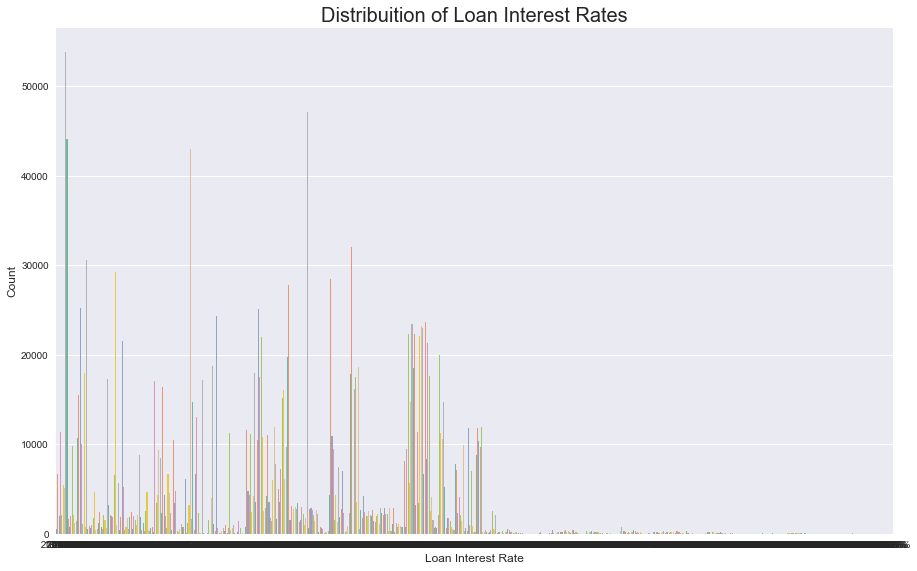

In [32]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

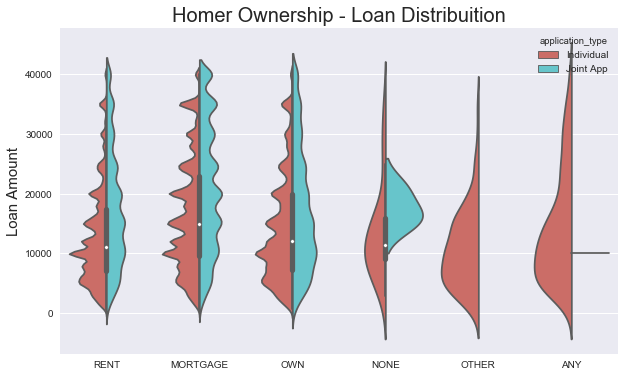

In [33]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


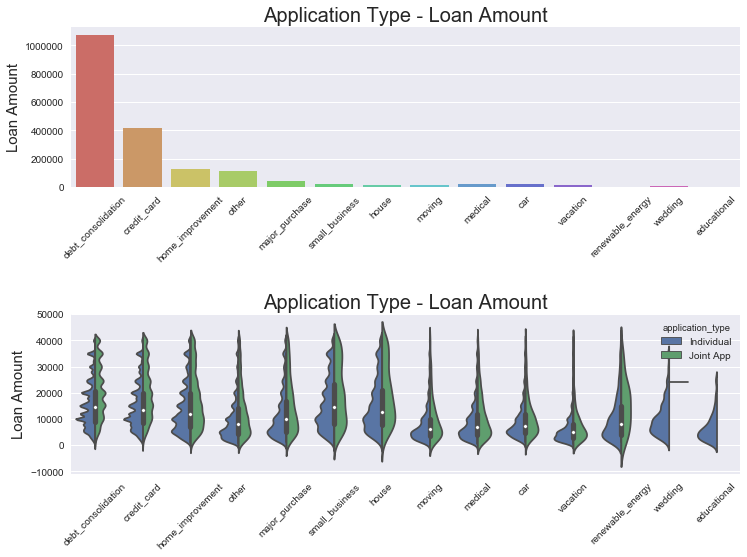

In [34]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

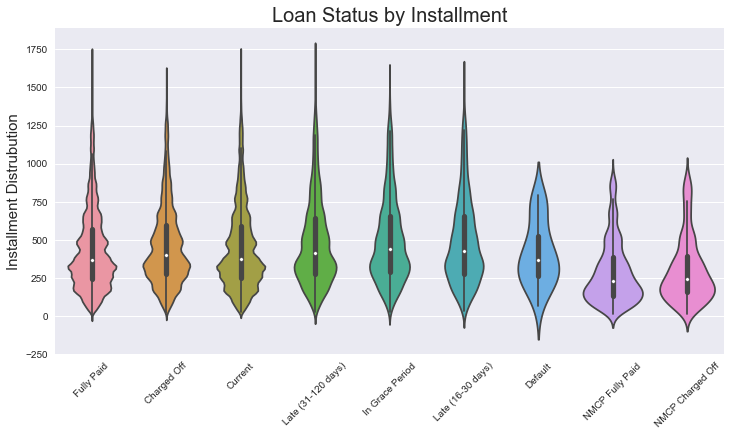

In [35]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

Current               812194
Fully Paid            811895
Charged Off           208657
Late (31-120 days)     19535
In Grace Period        13634
Late (16-30 days)       4602
NMCP Fully Paid         1988
NMCP Charged Off         761
Default                   24
Name: loan_status, dtype: int64


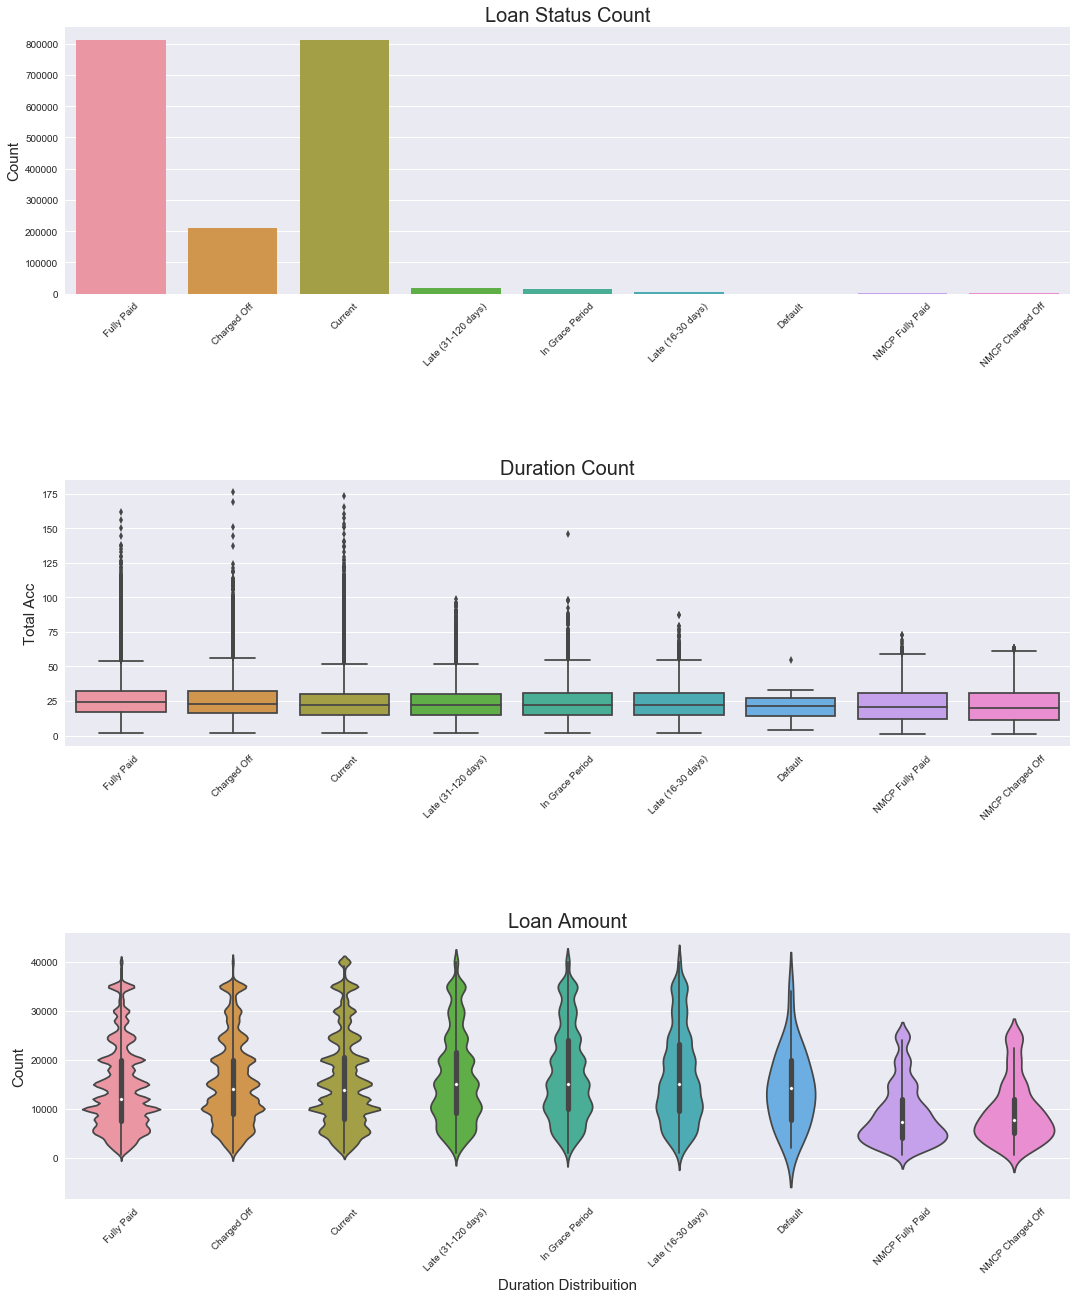

In [36]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show();